##  Example of how to create the CSV File that the NABat bulk uploader is looking for, based on a folder of wav files (that contain Guano metadata)

#### Guano metadata is great for interoperability and data sharing.

#### Between the content that is stored in the Guano MD and the content in the NABat file naming convention, nearly all the info we need is at hand.

In [1]:
from guano import GuanoFile

import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
dname = r"F:\1181"
d = Path(dname)
wavs = d.glob('**\*.wav')

In [3]:
%%time

rows = []
mds = []
for wav in wavs:
    g = GuanoFile(str(wav))
    md = dict(g.items())
    md['filepath'] = wav.parent
    md['filename'] = wav.name
    md['seconds'] = g.wav_params.nframes / g.wav_params.framerate
    mds.append(md)


Wall time: 1min 5s


### This gives us a dataframe of the Guano MD in that folder

In [5]:
df = pd.DataFrame(mds)
df.columns = [col.replace('|', '_').replace(' ', '_') for col in df.columns]
df.replace('noID', '', inplace=True)
df.head()

,GUANO_Version,Length,Note,SB_Classifier,SB_Filter_HP,SB_Region,SB_Species_Auto_ID,SB_Version,Samplerate,Species_Auto_ID,Species_Manual_ID,TE,Timestamp,filename,filepath,seconds
0,1.0,0.0,,south Great Basin,0,Great Basin,,4.2.1,192000.0,,,1.0,2017-07-12 21:40:04,NABAT-1181NE_20170712_214004.wav,F:\1181\NE,4.761333
1,1.0,0.0,,south Great Basin,0,Great Basin,,4.2.1,192000.0,,,1.0,2017-07-12 21:40:12,NABAT-1181NE_20170712_214012.wav,F:\1181\NE,2.677333
2,1.0,5.0,,south Great Basin,30,Great Basin,HiF,4.2.1,192000.0,HiF,Myev,1.0,2017-07-12 21:40:55,NABAT-1181NE_20170712_214055.wav,F:\1181\NE,4.984000
3,1.0,0.0,,south Great Basin,0,Great Basin,,4.2.1,192000.0,,,1.0,2017-07-12 21:41:01,NABAT-1181NE_20170712_214101.wav,F:\1181\NE,5.004000
4,1.0,5.0,,south Great Basin,5,Great Basin,,4.2.1,192000.0,,,1.0,2017-07-12 21:41:48,NABAT-1181NE_20170712_214148.wav,F:\1181\NE,5.004000


In [15]:
confirmed = df[~df.Species_Manual_ID.isin(['', 'Unconfirmed'])].dropna(subset=['Species_Manual_ID'])
confirmed.head()

,GUANO_Version,Length,Note,SB_Classifier,SB_Filter_HP,SB_Region,SB_Species_Auto_ID,SB_Version,Samplerate,Species_Auto_ID,Species_Manual_ID,TE,Timestamp,filename,filepath,seconds
2,1.0,5.0,,south Great Basin,30,Great Basin,HiF,4.2.1,192000.0,HiF,Myev,1.0,2017-07-12 21:40:55,NABAT-1181NE_20170712_214055.wav,F:\1181\NE,4.984000
37,1.0,5.0,,south Great Basin,5,Great Basin,Myth,4.2.1,192000.0,Myth,Myth,1.0,2017-07-12 22:13:42,NABAT-1181NE_20170712_221342.wav,F:\1181\NE,5.004000
40,1.0,5.0,,south Great Basin,5,Great Basin,,4.2.1,192000.0,,Tabr,1.0,2017-07-12 22:17:50,NABAT-1181NE_20170712_221750.wav,F:\1181\NE,5.004000
41,1.0,4.5,,south Great Basin,5,Great Basin,Lano,4.2.1,192000.0,Lano,Lano,1.0,2017-07-12 22:17:56,NABAT-1181NE_20170712_221756.wav,F:\1181\NE,4.526667
62,1.0,4.4,,south Great Basin,5,Great Basin,LoF,4.2.1,192000.0,LoF,Lano,1.0,2017-07-12 22:52:15,NABAT-1181NE_20170712_225215.wav,F:\1181\NE,4.360000


#### A quick plot of the classification results

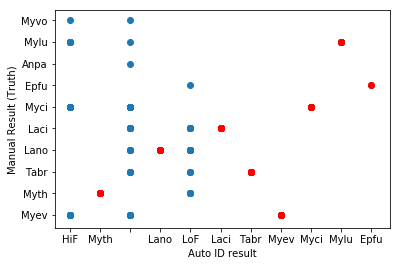

In [17]:

data = confirmed

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(data.Species_Auto_ID, data.Species_Manual_ID)

right= data[data.Species_Manual_ID==data.Species_Auto_ID]
ax.scatter(right.Species_Auto_ID, right.Species_Manual_ID, color='red')

ax.set_xlabel('Auto ID result')
ax.set_ylabel('Manual Result (Truth)')

plt.show()

## Now let's convert this to the format that NABat needs

#### A couple of helper functions we'll need...

In [18]:
from datetime import datetime, timedelta

def monitoring_night(dt):
    # return the sample night from a date time
    # if after midnight return previous date
    if dt.hour < 12:
        monitoringnight = dt.date() - timedelta(days=1)
    else:
        monitoringnight = dt.date()
        
    return monitoringnight
    

def parse_nabat_fname(fname):
    """If a file is in the format specified by NABat (grtsid_sitename_date_time.wav)
    parse it and return the components.  
    
    Allows for some discrepansies an malformations
    """
    f = Path(fname)
    name = f.stem
    if name.lower().startswith('nabat'):
        name = name[5:]
    if name.startswith('-'):
        name = name [1:]
        
    print()
        
    digit = name[0]
    grtsid = ''
    while digit.isnumeric():
        name = name [1:]
        grtsid += digit
        digit = name[0]
        
    if name.startswith('-'):
        name = name [1:]
        
    sitename, datestr, timestr = name.split('_')
    dt = datetime.strptime('T'.join([datestr, timestr]), "%Y%m%dT%H%M%S")

    
    return(grtsid, sitename, dt, monitoring_night(dt))

In [54]:
template = pd.read_csv(r"C:\Users\talbertc\Downloads\Bulk_Stationary_Acoustic_Template.csv")

In [55]:
template_lookup = {k:'' for k in template.columns}

In [56]:
template.columns

Index(['Grts Id', 'Location Name', 'Latitude Decimal Degrees (NAD83)',
       'Longitude Decimal Degrees (NAD83)', 'Activation Start Time',
       'Activation Stop Time', 'Detector', 'Microphone',
       'Microphone Orientation', 'Microphone Height (meters)',
       'Distance to Nearest Clutter (meters)', 'Clutter Type',
       'Distance to Nearest Water (meters)', 'Water Type', 'Percent Clutter',
       'Broad Habitat Type', 'Audio Recording Name (*.wav *.zc)',
       'Software Type', 'Auto Id', 'manual Id'],
      dtype='object')

In [48]:
def get_softwaretype(row):
    if 'SB_Version' in row:
        sb_version = row['SB_Version']
        if sb_version.startswith('4.2'):
            return 'SonoBat 4.2'
        elif sb_version.startswith('4'):
            return 'SonoBat 4.x'
        elif sb_version.startswith('3'):
            return 'SonoBat 3.x'
        
        else:
            raise Exception ("Need to add handles for Kaleidoscope")
            
get_softwaretype(confirmed.iloc[0])

'SonoBat 4.2'

In [46]:
confirmed.iloc[0]

GUANO_Version                                      1.0
Length                                               5
Note                                                  
SB_Classifier                        south Great Basin
SB_Filter_HP                                        30
SB_Region                                  Great Basin
SB_Species_Auto_ID                                 HiF
SB_Version                                       4.2.1
Samplerate                                      192000
Species_Auto_ID                                    HiF
Species_Manual_ID                                 Myev
TE                                                   1
Timestamp                          2017-07-12 21:40:55
filename              NABAT-1181NE_20170712_214055.wav
filepath                                    F:\1181\NE
seconds                                          4.984
Name: 2, dtype: object

In [22]:
species_list = "ANPA|CHME|CORA|COTO|EPFU|EUMA|EUFL|EUPE|EUUN|IDPH|LANO|LABL|LABO|LACI|LAEG|LAIN|LASE|LAXA|LENI|LEYE|MACA|MOMO|MOME|MYAU|MYAS|MYCA|MYCI|MYEV|MYGR|MYKE|MYLE|MYLU|MYSE|MYSO|MYTH|MYVE|MYVO|MYYU|NYHU|NYFE|NYMA|PAHE|PESU|TABR|ARJA|BRCA|DIEC|LAMI|MYAUR|MYAUS|MYOC|NOLE|STRU".split('|')

In [74]:
def get_nabat_row(guano_row):
    row = template_lookup.copy()
    fname = guano_row['filename']
    grtsid, sitename, dt, monitoring_night = parse_nabat_fname(fname)
    row['Grts Id'] = grtsid
    row['Location Name'] = sitename
    row['Activation Start Time'] = str(guano_row.Timestamp)
    row['Activation Stop Time'] = str(guano_row.Timestamp + timedelta(seconds=round(guano_row.seconds)))
    row['Detector'] = 'WILDLIFE ACOUSTICS SM4BAT-FS'
    row['Microphone'] = 'Wildlife Acoustics SMM-U1'
    row['Audio Recording Name (*.wav *.zc)'] = fname
    row['Software Type'] = get_softwaretype(guano_row)
    
    species = guano_row['Species_Auto_ID']
    row['Auto Id'] = species.upper()
#     else:
#         print(f'dropping species:{species}')
    
    species = guano_row['Species_Manual_ID']
    row['manual Id'] = species.upper()
#     else:
#         print(f'dropping species:{species}')
    
    infile = Path(guano_row.filepath).joinpath(guano_row.filename)
    outfile = sound_files.joinpath(guano_row.filename)

    shutil.copyfile(infile, outfile)
    
    
    return row



In [66]:
import shutil

to_upload = Path(dname).joinpath('files_for_nabat')
to_upload.mkdir(exist_ok=True)

sound_files = to_upload.joinpath('soundfiles')
sound_files.mkdir(exist_ok=True)

In [75]:
nabat_df = pd.DataFrame(list(confirmed.apply(get_nabat_row, axis=1)))

nabat_df = nabat_df[template.columns]


In [76]:
nabat_df.head()

,Grts Id,Location Name,Latitude Decimal Degrees (NAD83),Longitude Decimal Degrees (NAD83),Activation Start Time,Activation Stop Time,Detector,Microphone,Microphone Orientation,Microphone Height (meters),Distance to Nearest Clutter (meters),Clutter Type,Distance to Nearest Water (meters),Water Type,Percent Clutter,Broad Habitat Type,Audio Recording Name (*.wav *.zc),Software Type,Auto Id,manual Id
0,1181,NE,,,2017-07-12 21:40:55,2017-07-12 21:41:00,WILDLIFE ACOUSTICS SM4BAT-FS,Wildlife Acoustics SMM-U1,,,,,,,,,NABAT-1181NE_20170712_214055.wav,SonoBat 4.2,HIF,MYEV
1,1181,NE,,,2017-07-12 22:13:42,2017-07-12 22:13:47,WILDLIFE ACOUSTICS SM4BAT-FS,Wildlife Acoustics SMM-U1,,,,,,,,,NABAT-1181NE_20170712_221342.wav,SonoBat 4.2,MYTH,MYTH
2,1181,NE,,,2017-07-12 22:17:50,2017-07-12 22:17:55,WILDLIFE ACOUSTICS SM4BAT-FS,Wildlife Acoustics SMM-U1,,,,,,,,,NABAT-1181NE_20170712_221750.wav,SonoBat 4.2,,TABR
3,1181,NE,,,2017-07-12 22:17:56,2017-07-12 22:18:01,WILDLIFE ACOUSTICS SM4BAT-FS,Wildlife Acoustics SMM-U1,,,,,,,,,NABAT-1181NE_20170712_221756.wav,SonoBat 4.2,LANO,LANO
4,1181,NE,,,2017-07-12 22:52:15,2017-07-12 22:52:19,WILDLIFE ACOUSTICS SM4BAT-FS,Wildlife Acoustics SMM-U1,,,,,,,,,NABAT-1181NE_20170712_225215.wav,SonoBat 4.2,LOF,LANO


In [77]:
confirmed.head()

,GUANO_Version,Length,Note,SB_Classifier,SB_Filter_HP,SB_Region,SB_Species_Auto_ID,SB_Version,Samplerate,Species_Auto_ID,Species_Manual_ID,TE,Timestamp,filename,filepath,seconds
2,1.0,5.0,,south Great Basin,30,Great Basin,HiF,4.2.1,192000.0,HiF,Myev,1.0,2017-07-12 21:40:55,NABAT-1181NE_20170712_214055.wav,F:\1181\NE,4.984000
37,1.0,5.0,,south Great Basin,5,Great Basin,Myth,4.2.1,192000.0,Myth,Myth,1.0,2017-07-12 22:13:42,NABAT-1181NE_20170712_221342.wav,F:\1181\NE,5.004000
40,1.0,5.0,,south Great Basin,5,Great Basin,,4.2.1,192000.0,,Tabr,1.0,2017-07-12 22:17:50,NABAT-1181NE_20170712_221750.wav,F:\1181\NE,5.004000
41,1.0,4.5,,south Great Basin,5,Great Basin,Lano,4.2.1,192000.0,Lano,Lano,1.0,2017-07-12 22:17:56,NABAT-1181NE_20170712_221756.wav,F:\1181\NE,4.526667
62,1.0,4.4,,south Great Basin,5,Great Basin,LoF,4.2.1,192000.0,LoF,Lano,1.0,2017-07-12 22:52:15,NABAT-1181NE_20170712_225215.wav,F:\1181\NE,4.360000


In [79]:
out_csv = to_upload.joinpath('bulk_template.csv')
nabat_df.to_csv(out_csv, index=False)

In [80]:
nabat_df.shape

(192, 20)

In [33]:
detectors = "BINARY ACOUSTIC AR125|BINARY ACOUSTIC AR125-FG|BINARY ACOUSTIC AR180|BINARY ACOUSTIC iFR-V|BINARY ACOUSTIC AcroBat|PETTERSSON D1000x|PETTERSSON D240x|PETTERSSON D500x|PETTERSSON M500|TITLEY AnaBat Express|TITLEY AnaBat SD1|TITLEY AnaBat SD2|TITLEY AnaBat Walkabout|WILDLIFE ACOUSTICS EM-Touch|WILDLIFE ACOUSTICS EM-Touch2|WILDLIFE ACOUSTICS EM-TouchPRO|WILDLIFE ACOUSTICS EM3/EM3+|WILDLIFE ACOUSTICS SM2Bat-192|WILDLIFE ACOUSTICS SM2Bat+|WILDLIFE ACOUSTICS SM3Bat|WILDLIFE ACOUSTICS SM4BAT-FS".split("|")
detectors

['BINARY ACOUSTIC AR125',
 'BINARY ACOUSTIC AR125-FG',
 'BINARY ACOUSTIC AR180',
 'BINARY ACOUSTIC iFR-V',
 'BINARY ACOUSTIC AcroBat',
 'PETTERSSON D1000x',
 'PETTERSSON D240x',
 'PETTERSSON D500x',
 'PETTERSSON M500',
 'TITLEY AnaBat Express',
 'TITLEY AnaBat SD1',
 'TITLEY AnaBat SD2',
 'TITLEY AnaBat Walkabout',
 'WILDLIFE ACOUSTICS EM-Touch',
 'WILDLIFE ACOUSTICS EM-Touch2',
 'WILDLIFE ACOUSTICS EM-TouchPRO',
 'WILDLIFE ACOUSTICS EM3/EM3+',
 'WILDLIFE ACOUSTICS SM2Bat-192',
 'WILDLIFE ACOUSTICS SM2Bat+',
 'WILDLIFE ACOUSTICS SM3Bat',
 'WILDLIFE ACOUSTICS SM4BAT-FS']

In [32]:
mics = "Wildlife Acoustics SMM-U1|Pettersson M500|Wildlife Acoustics SM3-U1|Wildlife Acoustics SMM-U2|Wildlife Acoustics SMX-US|Wildlife Acoustics SMX-UT|generic Directional|generic Extended Mic|generic Hi-Mic|generic Omni-directional|generic Regular|Wildlife Acoustics SMX-U1|generic Internal -Required".split("|")
mics

['Wildlife Acoustics SMM-U1',
 'Pettersson M500',
 'Wildlife Acoustics SM3-U1',
 'Wildlife Acoustics SMM-U2',
 'Wildlife Acoustics SMX-US',
 'Wildlife Acoustics SMX-UT',
 'generic Directional',
 'generic Extended Mic',
 'generic Hi-Mic',
 'generic Omni-directional',
 'generic Regular',
 'Wildlife Acoustics SMX-U1',
 'generic Internal -Required']

In [113]:
js_template = pd.read_csv(r"C:\Users\talbertc\Downloads\CO NABAT 2015 Bulk_Stationary_Acoustic_Template.csv").iloc[1:, :16].fillna(method='ffill')

js_template.head()

,Grts Id,Location Name,Latitude Decimal Degrees (NAD83),Longitude Decimal Degrees (NAD83),Activation Start Time,Activation Stop Time,Detector,Microphone,Microphone Orientation,Microphone Height (meters),Distance to Nearest Clutter (meters),Clutter Type,Distance to Nearest Water (meters),Water Type,Percent Clutter,Broad Habitat Type
1,2,NW,170440,4355996,7/2/2015,NaN,SM2Bat+,SMX-US,NaN,2,NaN,vegetation,NaN,NaN,NaN,shrubland
2,2,NW,170440,4355996,7/3/2015,NaN,SM2Bat+,SMX-US,NaN,2,NaN,vegetation,NaN,NaN,NaN,shrubland
3,2,NW,170440,4355996,7/4/2015,NaN,SM2Bat+,SMX-US,NaN,2,NaN,vegetation,NaN,NaN,NaN,shrubland
4,2,NW,170440,4355996,7/5/2015,NaN,SM2Bat+,SMX-US,NaN,2,NaN,vegetation,NaN,NaN,NaN,shrubland
5,2,SW,174304,4354564,7/2/2015,NaN,SM2Bat+,SMX-US,NaN,2,NaN,vegetation,NaN,NaN,NaN,shrubland


In [101]:


x1,y1 = 431770, 4188115
x2,y2 = transform(inProj,outProj,x1,y1)
print(x2,y2)

-105.7754212244436 37.83791651934307


In [121]:
from pyproj import Proj, transform

inProj = Proj(init='epsg:32613')
outProj = Proj(init='epsg:4326')

def to_lat_long(row):
    y = row['Latitude Decimal Degrees (NAD83)']
    x = row['Longitude Decimal Degrees (NAD83)']

    long, lat = transform(inProj, outProj, y ,x)
    return (lat, long)
    
coords =  js_template.apply(to_lat_long, axis=1)

In [125]:
js_template[['Latitude Decimal Degrees (NAD83)', 'Longitude Decimal Degrees (NAD83)']] = coords.apply(pd.Series)

In [134]:
dropme = js_template.duplicated(subset=['Latitude Decimal Degrees (NAD83)',
 'Longitude Decimal Degrees (NAD83)',
 'Detector',
 'Microphone',
 'Microphone Orientation',
 'Microphone Height (meters)',
 'Distance to Nearest Clutter (meters)',
 'Clutter Type',
 'Distance to Nearest Water (meters)',
 'Water Type',
 'Percent Clutter',
 'Broad Habitat Type'], keep='first')

js_template[~dropme].to_csv(r"C:\Users\talbertc\Downloads\CO NABAT 2015 Bulk_Stationary_Acoustic_Template_reformated.csv", index=False)

In [132]:
js_template.to

(300, 16)

In [ ]:
['Latitude Decimal Degrees (NAD83)',
 'Longitude Decimal Degrees (NAD83)',
 'Detector',
 'Microphone',
 'Microphone Orientation',
 'Microphone Height (meters)',
 'Distance to Nearest Clutter (meters)',
 'Clutter Type',
 'Distance to Nearest Water (meters)',
 'Water Type',
 'Percent Clutter',
 'Broad Habitat Type']